In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
# wr = pd.read_csv("../data/weather/weather_report_2709555247418929082.csv", parse_dates=["Date"])
# wr = pd.read_csv("../data/weather/weather_report_1620322523.634392.csv", parse_dates=["Date"])
wr = pd.read_csv("../data/weather/weather_report_1620408982.771627.csv", parse_dates=["Date"])
wr = wr[~wr.duplicated()]

In [19]:
wr["Hour"] = pd.Timedelta('1h') * wr["Hour"]/100

In [20]:
wr["Time"] = wr["Date"] + wr["Hour"]

In [5]:
# wr.columns = wr.columns.str.lower()
# wr.columns = wr.columns.str.replace("%", "perc")
# wr.columns = wr.columns.str.replace("°", "degrees")
# wr.columns = wr.columns.str.replace(" ", "")
# wr.columns

In [6]:
#wr.groupby("Station").max().sort_values("Date")

,Date,Julian,Hour,Standard,ZipCodes,Scope,HlyAirTmp (F),HlyDewPnt (F),HlyEto (in),HlyNetRad (Ly/day),...,HlyAsceEtr (in),HlyPrecip (in),HlyRelHum (%),HlyResWind (MPH),HlySoilTmp (F),HlySolRad (Ly/day),HlyVapPres (mBars),HlyWindDir (°),HlyWindSpd (MPH),Time
Station,,,,,,,,,,,,,,,,,,,,,
217,2020-11-30,335,1 days,english,"91360, 91362, 93021, 93065",hourly,79.1,38.6,0.02,526.0,...,NaN,0.00,42.0,8.8,61.7,1247.0,7.9,359.0,9.1,2020-12-01
250,2020-12-15,350,1 days,english,"95987, 95955, 95932, 95912",hourly,73.2,51.5,0.02,487.0,...,NaN,0.14,100.0,20.0,51.5,1007.0,13.0,359.0,20.2,2020-12-16
251,2020-12-15,350,1 days,english,"92346, 92374",hourly,77.0,47.1,0.02,540.0,...,NaN,0.03,86.0,10.4,54.4,1128.0,11.0,348.0,11.0,2020-12-16
6,2021-01-22,360,1 days,english,"95618, 95617, 95616",hourly,72.8,54.2,0.03,549.0,...,NaN,0.17,100.0,22.8,55.0,1089.0,14.4,360.0,23.1,2021-01-23
198,2021-01-22,335,1 days,english,93060,hourly,89.0,49.9,0.03,642.0,...,NaN,0.00,92.0,20.3,62.4,1318.0,12.2,358.0,21.5,2021-01-23
255,2021-01-22,22,1 days,english,"91708, 91710",hourly,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-23


In [7]:
#wr.groupby("Station").mean()

,Julian,HlyAirTmp (F),HlyDewPnt (F),HlyEto (in),HlyNetRad (Ly/day),HlyAsceEto (in),HlyAsceEtr (in),HlyPrecip (in),HlyRelHum (%),HlyResWind (MPH),HlySoilTmp (F),HlySolRad (Ly/day),HlyVapPres (mBars),HlyWindDir (°),HlyWindSpd (MPH)
Station,,,,,,,,,,,,,,,
6,242.815789,49.286732,36.802522,0.002467,42.445175,0.002544,NaN,0.001831,68.359649,4.995724,48.733662,196.714912,7.758772,214.050439,5.255154
198,80.000000,60.390000,29.643056,0.005194,61.916667,0.005667,NaN,0.000000,37.541667,4.456111,56.167778,279.283333,5.810278,158.841667,5.300278
217,334.000000,63.175000,19.420833,0.004028,28.333333,0.005417,NaN,0.000000,19.819444,3.494444,60.755556,318.652778,3.759722,107.944444,4.316667
250,344.000000,48.600000,34.126923,0.002660,31.673077,0.002532,NaN,0.001699,62.403846,5.371154,50.273397,189.820513,6.867949,218.298077,5.815064
251,344.000000,53.836218,25.228846,0.002244,39.019231,0.002821,NaN,0.000417,39.737179,2.270968,52.721154,221.464744,5.083333,132.589744,3.054808
255,16.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#wr.groupby(["Station", wr.Date.dt.month]).count()

Date  Julian  Hour  Standard  ZipCodes  Scope  HlyAirTmp (F)  \
Station Date                                                                 
6       1      288     288   288       288       288    288            288   
        11      72      72    72        72        72     72             72   
        12     552     552   552       552       552    552            552   
198     1      288     288   288       288       288    288            288   
        11      72      72    72        72        72     72             72   
217     11      72      72    72        72        72     72             72   
250     12     312     312   312       312       312    312            312   
251     12     312     312   312       312       312    312            312   
255     1      288     288   288       288       288    288              0   

              HlyDewPnt (F)  HlyEto (in)  HlyNetRad (Ly/day)  ...  \
Station Date                                                  ...   
6       1               288          288                 288  ...   
        11               72           72                  72  ...   
        12              552          552                 552  ...   
198     1               288          288                 288  ...   
        11               72           72                  72  ...   
217     11               72           72                  72  ...   
250     12              312          312                 312  ...   
251     12              312          312                 312  ...   
255     1                 0            0                   0  ...   

              HlyAsceEtr (in)  HlyPrecip (in)  HlyRelHum (%)  \
Station Date                                                   
6       1                   0             288            288   
        11                  0              72             72   
        12                  0             552            552   
198     1                   0             288            288   
        11                  0              72             72   
217     11                  0              72             72   
250     12                  0             312            312   
251     12                  0             312            312   
255     1                   0               0              0   

              HlyResWind (MPH)  HlySoilTmp (F)  HlySolRad (Ly/day)  \
Station Date                                                         
6       1                  288             288                 288   
        11                  72              72                  72   
        12                 552             552                 552   
198     1                  288             288                 288   
        11                  72              72                  72   
217     11                  72              72                  72   
250     12                 312             312                 312   
251     12                 310             312                 312   
255     1                    0               0                   0   

              HlyVapPres (mBars)  HlyWindDir (°)  HlyWindSpd (MPH)  Time  
Station Date                                                              
6       1                    288             288               288   288  
        11                    72              72                72    72  
        12                   552             552               552   552  
198     1                    288             288               288   288  
        11                    72              72                72    72  
217     11                    72              72                72    72  
250     12                   312             312               312   312  
251     12                   312             312               312   312  
255     1                      0               0                 0   288  

[9 rows x 21 columns]

Text(0, 0.5, 'Humidity')

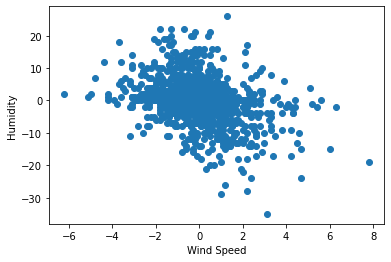

In [77]:
ax = plt.axes()
wr212 = wr[wr.Station==121]
plt.scatter(wr212["HlyWindSpd (MPH)"].diff().values, wr212["HlyRelHum (%)"].diff().values)
ax.set_xlabel("Wind Speed")
ax.set_ylabel("Humidity")

In [79]:
wr.corr()

,Julian,Station,HlyAirTmp (F),HlyDewPnt (F),HlyEto (in),HlyNetRad (Ly/day),HlyAsceEto (in),HlyAsceEtr (in),HlyPrecip (in),HlyRelHum (%),HlyResWind (MPH),HlySoilTmp (F),HlySolRad (Ly/day),HlyVapPres (mBars),HlyWindDir (°),HlyWindSpd (MPH)
Julian,1.000000,-0.000368,-0.068454,-0.095268,-0.016390,-0.020608,-0.011606,-0.013623,-0.042115,-0.062637,-0.073370,0.012483,-0.016853,-0.149968,0.003704,-0.074673
Station,-0.000368,1.000000,-0.002883,-0.034938,-0.000261,-0.005350,-0.002244,-0.022728,0.002584,-0.012622,0.028731,-0.022907,0.005771,-0.020869,-0.047632,0.029827
HlyAirTmp (F),-0.068454,-0.002883,1.000000,0.136247,0.549097,0.482456,0.581998,0.621691,-0.018693,-0.611009,0.230733,0.493938,0.520071,0.200888,0.065479,0.247400
HlyDewPnt (F),-0.095268,-0.034938,0.136247,1.000000,-0.070464,0.069833,-0.079611,-0.058205,0.095808,0.597775,-0.041075,0.234023,-0.014802,0.872894,0.027069,-0.056304
HlyEto (in),-0.016390,-0.000261,0.549097,-0.070464,1.000000,0.852986,0.919037,0.864390,-0.061973,-0.468464,0.297589,0.041477,0.869933,-0.072727,0.081261,0.329817
HlyNetRad (Ly/day),-0.020608,-0.005350,0.482456,0.069833,0.852986,1.000000,0.847353,0.856385,-0.049667,-0.319534,0.176864,-0.028183,0.983901,0.080536,0.101451,0.207669
HlyAsceEto (in),-0.011606,-0.002244,0.581998,-0.079611,0.919037,0.847353,1.000000,NaN,-0.064751,-0.494165,0.267429,0.055057,0.873549,-0.082425,0.092599,0.300934
HlyAsceEtr (in),-0.013623,-0.022728,0.621691,-0.058205,0.864390,0.856385,NaN,1.000000,-0.049455,-0.564933,0.394153,-0.079150,0.877342,-0.040632,-0.053495,0.392163
HlyPrecip (in),-0.042115,0.002584,-0.018693,0.095808,-0.061973,-0.049667,-0.064751,-0.049455,1.000000,0.126271,0.092645,-0.008893,-0.063699,0.130873,-0.026315,0.100578
HlyRelHum (%),-0.062637,-0.012622,-0.611009,0.597775,-0.468464,-0.319534,-0.494165,-0.564933,0.126271,1.000000,-0.222083,-0.145723,-0.412807,0.599121,-0.039953,-0.249258


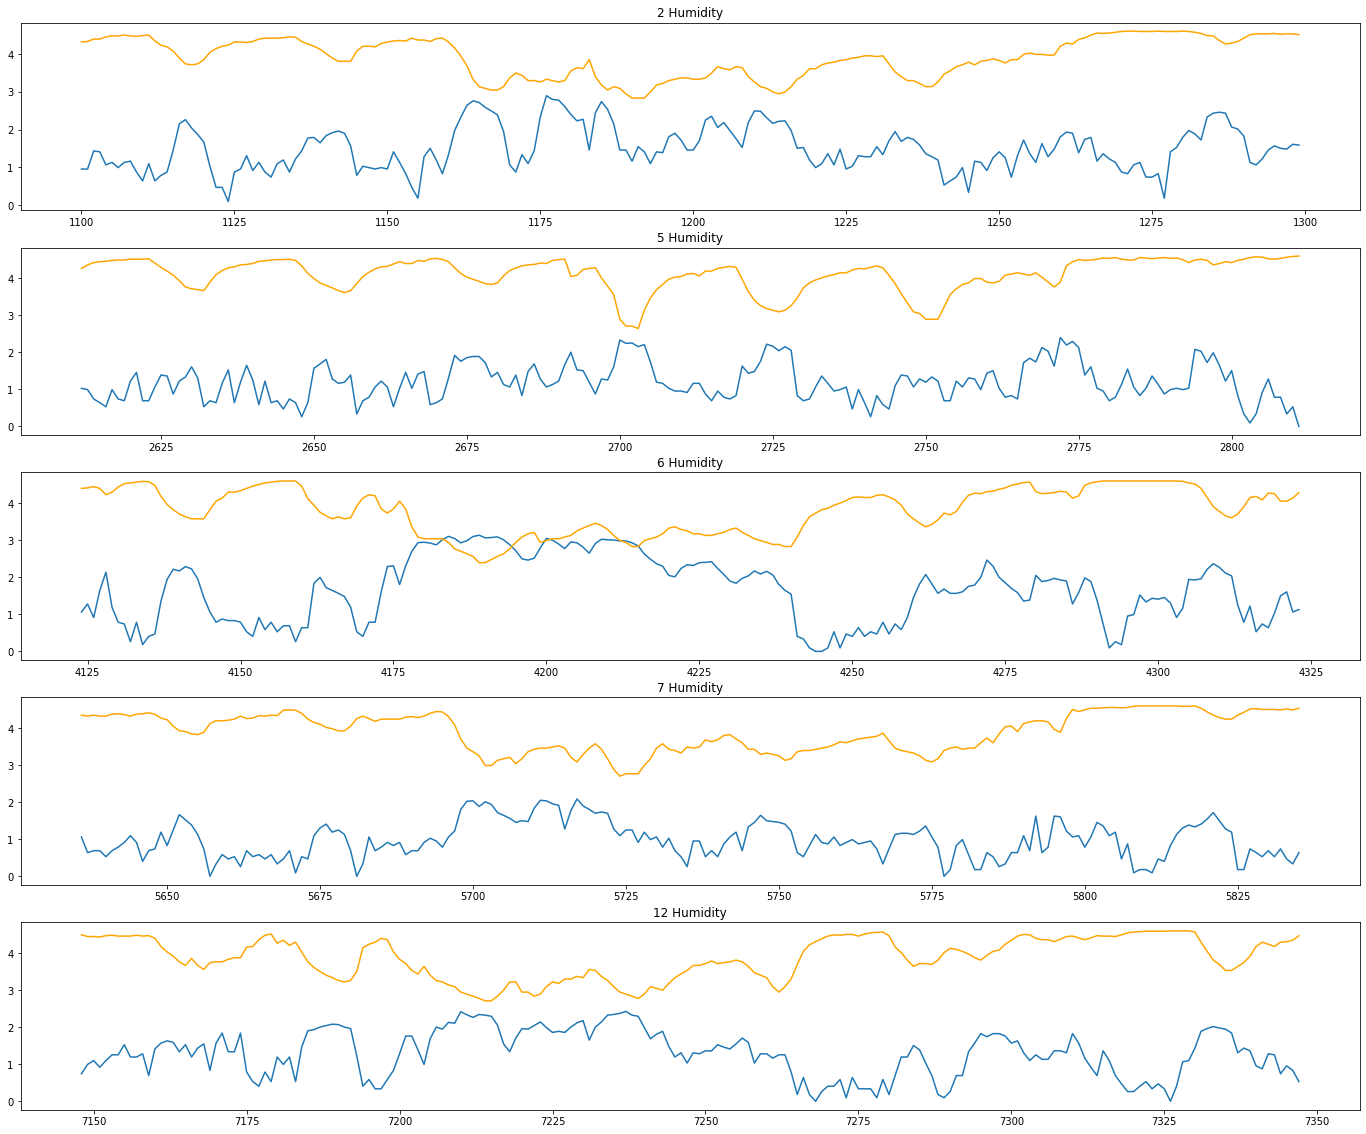

In [70]:
stations = wr.Station.unique()
fig, ax = plt.subplots(5,1,figsize=(24,20))
for (s, v_ax) in zip(stations[:-1], ax):
        wrs = wr[wr.Station==s].iloc[1100:1300]
        v_ax.plot(np.log(wrs["HlyWindSpd (MPH)"]))
        v_ax.set_title("{} Wind Speed".format(s))
        
#         v_ax[1].hist(wrs["HlyWindSpd (MPH)"].diff(), bins=30)
#         v_ax[1].set_title("{} Wind Speed Increments".format(s))
        
        v_ax.plot(np.log(wrs["HlyRelHum (%)"]), color="orange")
        v_ax.set_title("{} Humidity".format(s))
        
#         v_ax[3].hist(wrs["HlyRelHum (%)"].diff(), bins=30)
#         v_ax[3].set_title("{} Humidity".format(s))

(<AxesSubplot:>,)

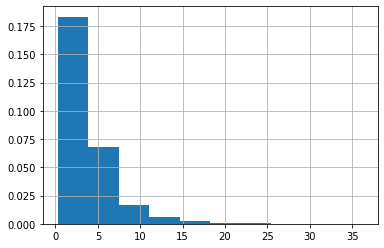

In [53]:
wr["HlyWindSpd (MPH)"].hist(density=True, cumulative=False), 

In [51]:
wr["HlyWindSpd (MPH)"].describe()

count    1968.000000
mean        4.969004
std         4.073195
min         1.000000
25%         2.400000
50%         3.400000
75%         6.100000
max        23.100000
Name: HlyWindSpd (MPH), dtype: float64

In [54]:
wr.columns

Index(['Date', 'Julian', 'Hour', 'Station', 'Standard', 'ZipCodes', 'Scope',
       'HlyAirTmp (F)', 'HlyDewPnt (F)', 'HlyEto (in)', 'HlyNetRad (Ly/day)',
       'HlyAsceEto (in)', 'HlyAsceEtr (in)', 'HlyPrecip (in)', 'HlyRelHum (%)',
       'HlyResWind (MPH)', 'HlySoilTmp (F)', 'HlySolRad (Ly/day)',
       'HlyVapPres (mBars)', 'HlyWindDir (°)', 'HlyWindSpd (MPH)', 'Time'],
      dtype='object')

# PyOD

In [11]:
import pyod
from pyod.models.copod import COPOD

In [12]:
wr = pd.read_csv("../data/weather/weather_report_2709555247418929082.csv")
hly_cols = wr.columns[wr.columns.str.contains("Hly")]
wr_train = wr[hly_cols].dropna(axis=1, how="all").dropna(axis=0, how="any")

In [14]:
clf = COPOD()
clf.fit(wr_train)
outlier_scores = clf.decision_scores_
outlier_scores = pd.Series(clf.decision_scores_, index=wr_train.index)

In [15]:
outlier_scores.describe(percentiles=np.arange(0,1,.01))

count    1990.000000
mean       14.069710
std         5.334305
min         7.178627
0%          7.178627
            ...     
96%        26.066235
97%        27.840614
98%        30.048138
99%        32.792862
max        45.072450
Length: 105, dtype: float64

In [16]:
wr_outliers = wr.iloc[wr_train[outlier_scores > 25].index]

,Date,Julian,Hour,Station,Standard,ZipCodes,Scope,HlyAirTmp (F),HlyDewPnt (F),HlyEto (in),...,HlyAsceEto (in),HlyAsceEtr (in),HlyPrecip (in),HlyRelHum (%),HlyResWind (MPH),HlySoilTmp (F),HlySolRad (Ly/day),HlyVapPres (mBars),HlyWindDir (°),HlyWindSpd (MPH)
443,2020-12-07,342,1200,6,english,"95618, 95617, 95616",hourly,66.2,30.6,0.02,...,0.02,NaN,0.00,26.0,16.0,49.1,953.0,5.8,275.0,16.2
591,2020-12-13,348,1600,6,english,"95618, 95617, 95616",hourly,52.3,52.0,0.00,...,0.00,NaN,0.09,99.0,9.2,50.0,73.0,13.2,97.0,9.2
708,2021-01-13,13,1300,6,english,"95618, 95617, 95616",hourly,60.7,53.7,0.01,...,0.01,NaN,0.00,78.0,5.8,50.9,759.0,14.1,355.0,6.1
824,2021-01-18,18,900,6,english,"95618, 95617, 95616",hourly,62.2,19.0,0.01,...,0.02,NaN,0.00,19.0,22.1,49.9,314.0,3.6,342.0,22.4
825,2021-01-18,18,1000,6,english,"95618, 95617, 95616",hourly,64.5,18.1,0.02,...,0.02,NaN,0.00,16.0,20.9,49.9,668.0,3.4,346.0,21.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1643,2020-12-14,349,1200,251,english,"92346, 92374",hourly,61.6,26.7,0.02,...,0.02,NaN,0.00,26.0,10.4,52.6,1029.0,4.9,342.0,11.0
1763,2020-12-06,341,1200,250,english,"95987, 95955, 95932, 95912",hourly,64.3,35.5,0.02,...,0.02,NaN,0.00,34.0,14.9,49.2,1007.0,7.0,350.0,15.2
1786,2020-12-07,342,1100,250,english,"95987, 95955, 95932, 95912",hourly,64.5,31.2,0.02,...,0.02,NaN,0.00,28.0,19.1,50.5,838.0,5.9,347.0,19.4
1787,2020-12-07,342,1200,250,english,"95987, 95955, 95932, 95912",hourly,67.4,30.6,0.02,...,0.02,NaN,0.00,25.0,18.1,50.5,952.0,5.8,344.0,18.5


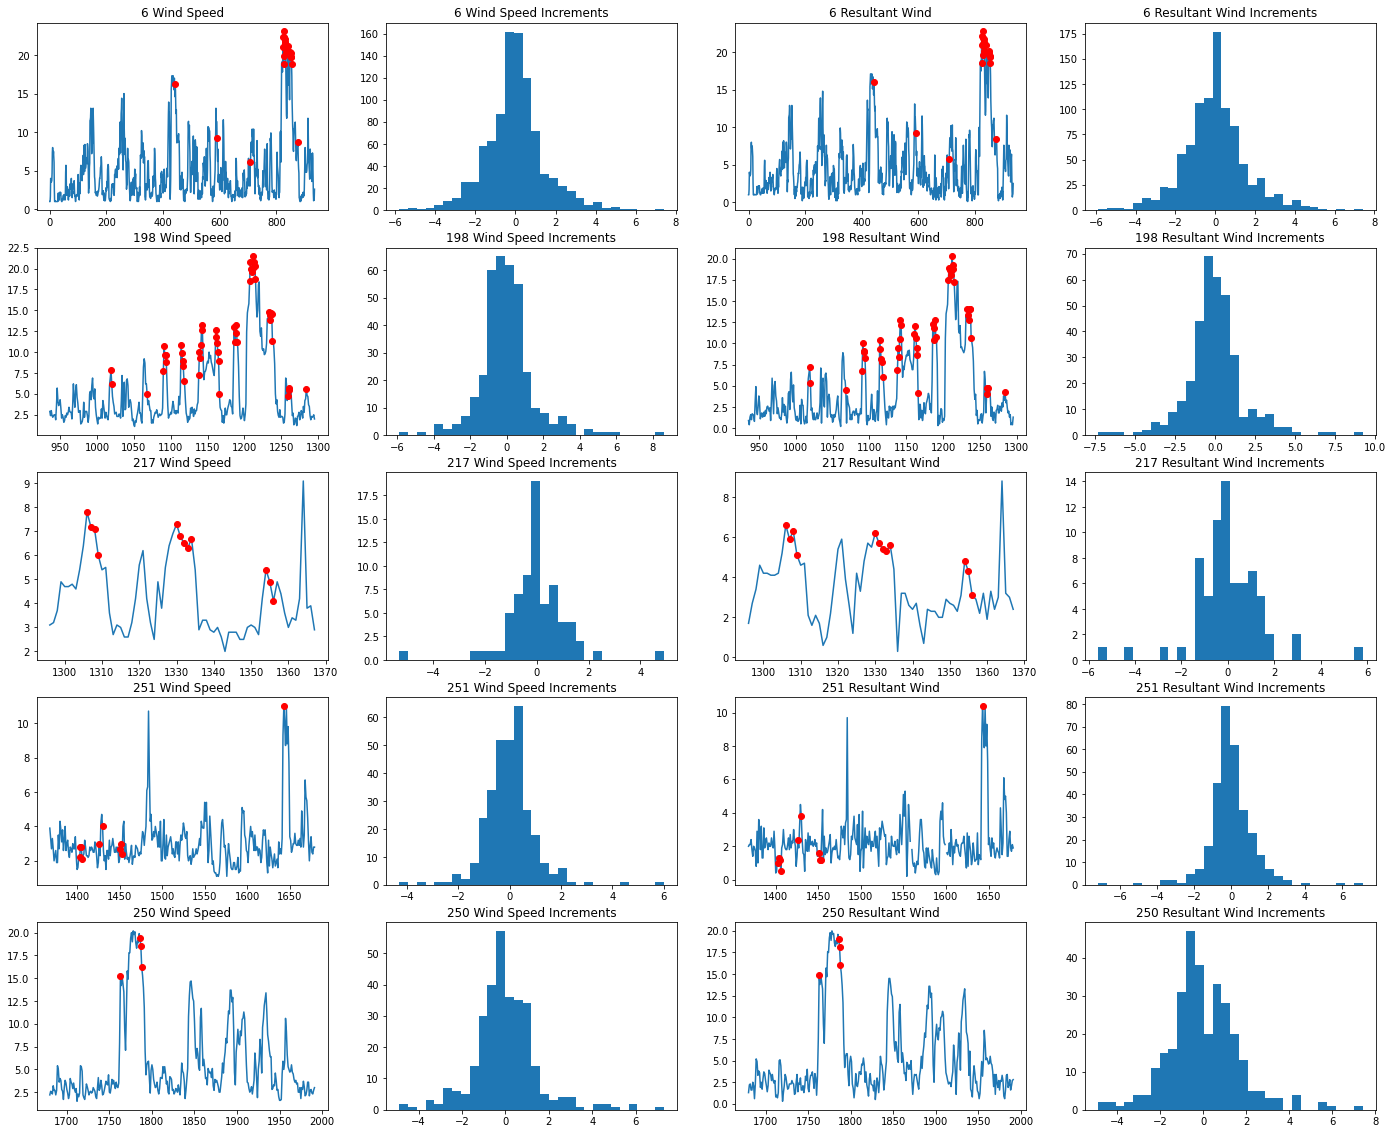

In [17]:
stations = wr.Station.unique()
fig, ax = plt.subplots(5,4,figsize=(24,20))
for (s, v_ax) in zip(stations[:-1], ax):
        wrs = wr[wr.Station==s]
        v_ax[0].plot(wrs["HlyWindSpd (MPH)"])
        v_ax[0].plot(wr_outliers[wr_outliers.Station == s]["HlyWindSpd (MPH)"], 'o', color="red")
        v_ax[0].set_title("{} Wind Speed".format(s))
        
        v_ax[1].hist(wrs["HlyWindSpd (MPH)"].diff(), bins=30)
        v_ax[1].set_title("{} Wind Speed Increments".format(s))
        
        v_ax[2].plot(wrs["HlyResWind (MPH)"])
        v_ax[2].plot(wr_outliers[wr_outliers.Station == s]["HlyResWind (MPH)"], 'o', color="red")
        v_ax[2].set_title("{} Resultant Wind".format(s))
        
        v_ax[3].hist(wrs["HlyResWind (MPH)"].diff(), bins=30)
        v_ax[3].set_title("{} Resultant Wind Increments".format(s))

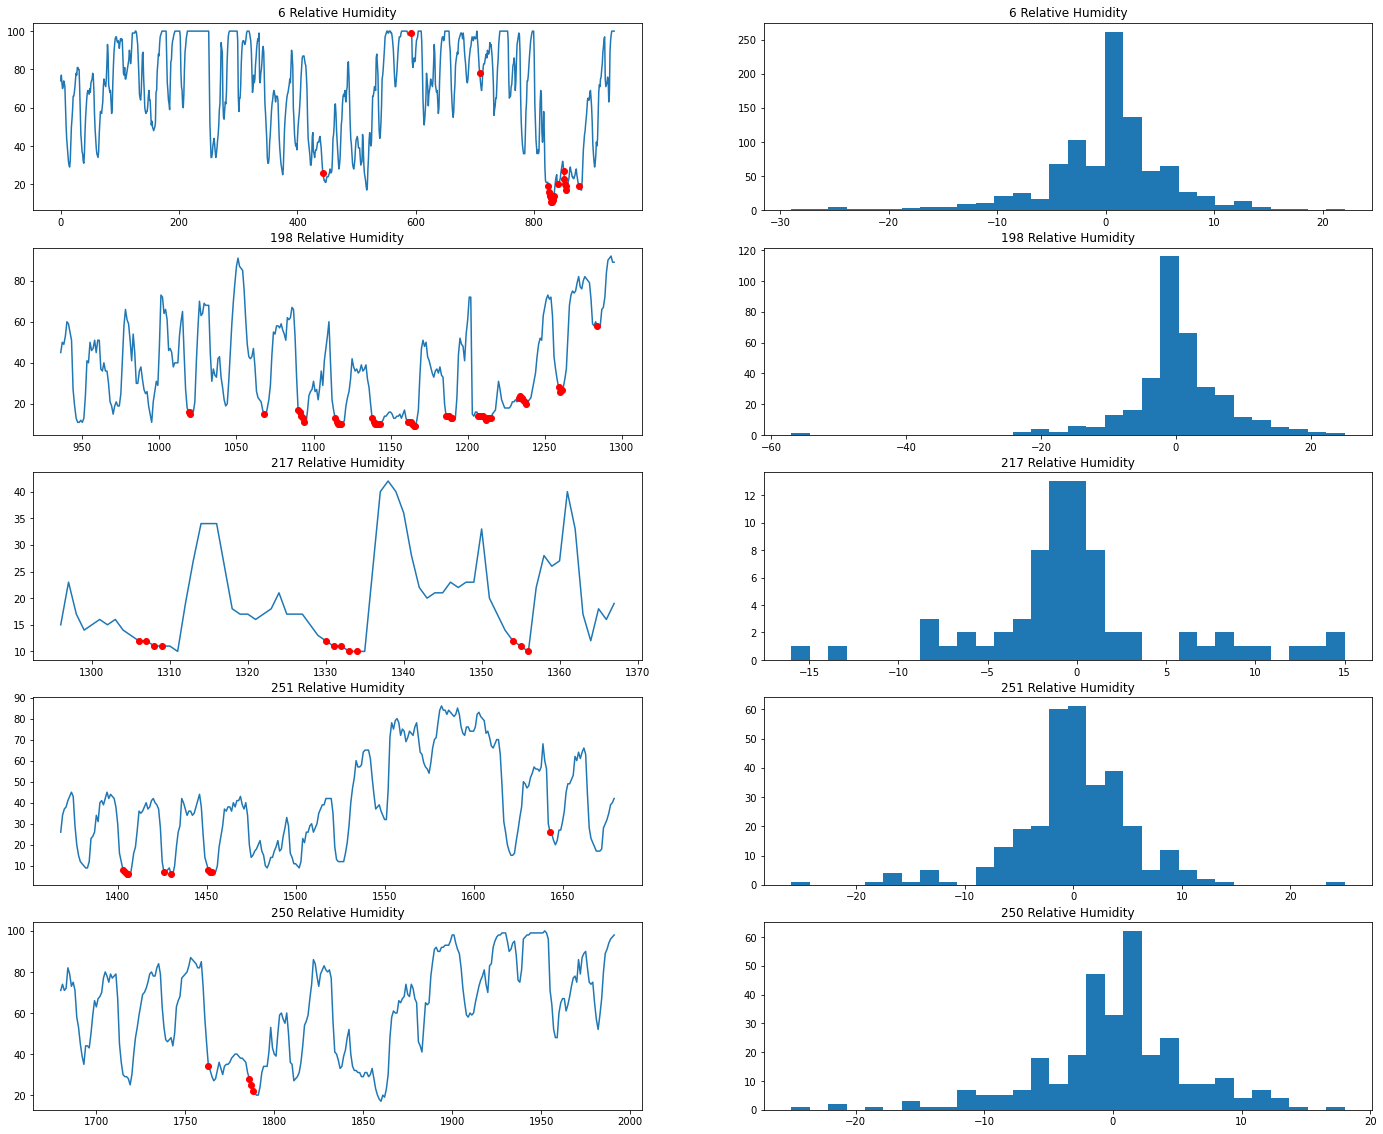

In [18]:
stations = wr.Station.unique()
fig, ax = plt.subplots(5,2,figsize=(24,20))
for (s, v_ax) in zip(stations[:-1], ax):
        wrs = wr[wr.Station==s]
        v_ax[0].plot(wrs["HlyRelHum (%)"])
        v_ax[0].plot(wr_outliers[wr_outliers.Station == s]["HlyRelHum (%)"], 'o', color="red")
        v_ax[0].set_title("{} Relative Humidity".format(s))
        
        v_ax[1].hist(wrs["HlyRelHum (%)"].diff(), bins=30)
        v_ax[1].set_title("{} Relative Humidity".format(s))

# Banpei

In [11]:
import banpei

In [12]:
model = banpei.SST(w=10)

In [25]:
wr_sample = wr.loc[wr.Station==6, "HlyWindSpd (MPH)"]

0      1.0
1      1.0
2      1.7
3      4.0
4      3.7
      ... 
931    2.1
932    1.1
933    1.3
934    1.2
935    2.6
Name: HlyWindSpd (MPH), Length: 936, dtype: float64

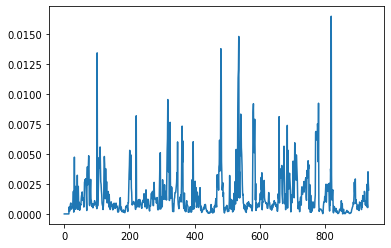

In [14]:
outlier_scores = pd.Series(model.detect(wr_sample))
plt.plot(outlier_scores)

In [17]:
outlier_scores.describe(percentiles=np.arange(0,1,.05))

count    936.000000
mean       0.001551
std        0.001910
min        0.000000
0%         0.000000
5%         0.000119
10%        0.000202
15%        0.000288
20%        0.000385
25%        0.000475
30%        0.000572
35%        0.000632
40%        0.000722
45%        0.000813
50%        0.000893
55%        0.000986
60%        0.001118
65%        0.001283
70%        0.001560
75%        0.001863
80%        0.002292
85%        0.002852
90%        0.003612
95%        0.005297
max        0.016458
dtype: float64

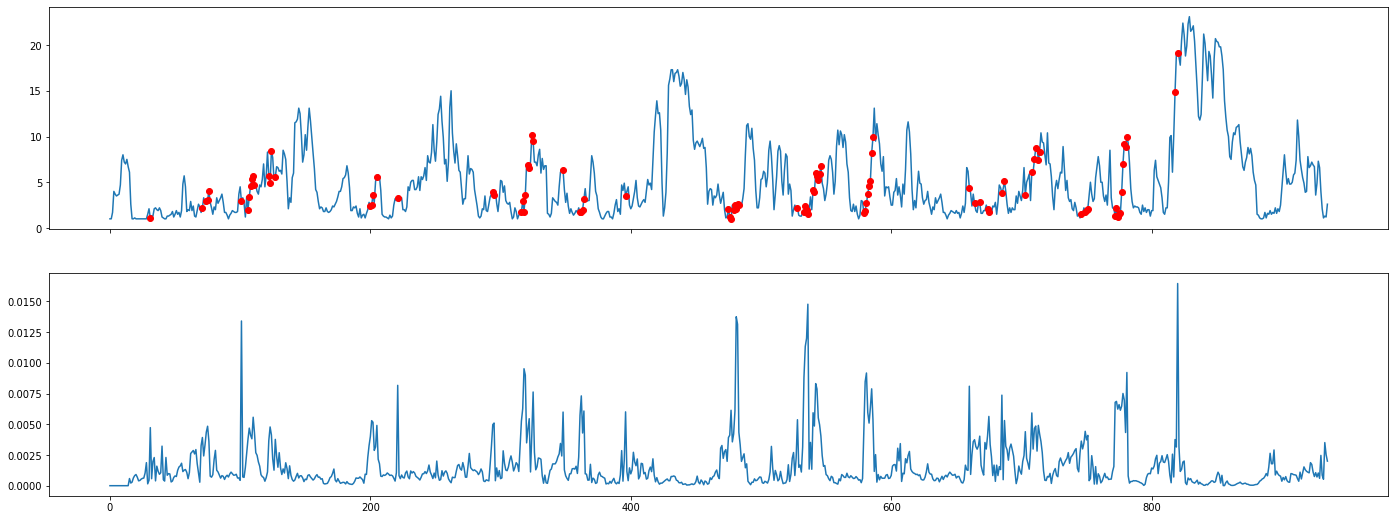

In [22]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(24,9))
ax[0].plot(wr_sample)
ax[0].plot(wr_sample[outlier_scores>outlier_scores.describe(percentiles=np.arange(0,1,.05))["90%"]], 'o', color="red")
ax[1].plot(outlier_scores)

# ADTK

In [7]:
import adtk

In [111]:
wr_adtk = wr[wr.Station==6][["Time", "HlyWindSpd (MPH)"]]
wr_adtk.set_index("Time", inplace=True)

In [112]:
from adtk.detector import QuantileAD
quantile_ad = QuantileAD(high=0.99, low=0.01)
anomalies = quantile_ad.fit_detect(wr_adtk)

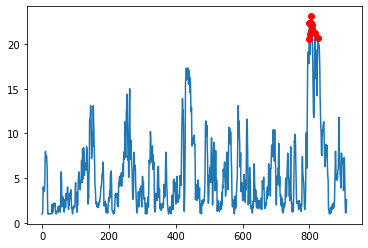

In [113]:
plt.plot(wr_adtk.values)
plt.plot(wr_adtk[anomalies].values, 'o', color='red')

In [129]:
wr_adtk = wr[wr.Station==6][["Time", "HlyRelHum (%)", "HlyWindSpd (MPH)"]]
wr_adtk.set_index("Time", inplace=True)
wr_adtk.head()

,HlyRelHum (%),HlyWindSpd (MPH)
Time,,
2020-11-28 01:00:00,74.0,1.0
2020-11-28 02:00:00,77.0,1.0
2020-11-28 03:00:00,73.0,1.7
2020-11-28 04:00:00,70.0,4.0
2020-11-28 05:00:00,71.0,3.7


In [130]:
from adtk.detector import PcaAD
pca_ad = PcaAD(k=1)
anomalies = pca_ad.fit_detect(wr_adtk)

Text(0.5, 1.0, 'Wind Speed')

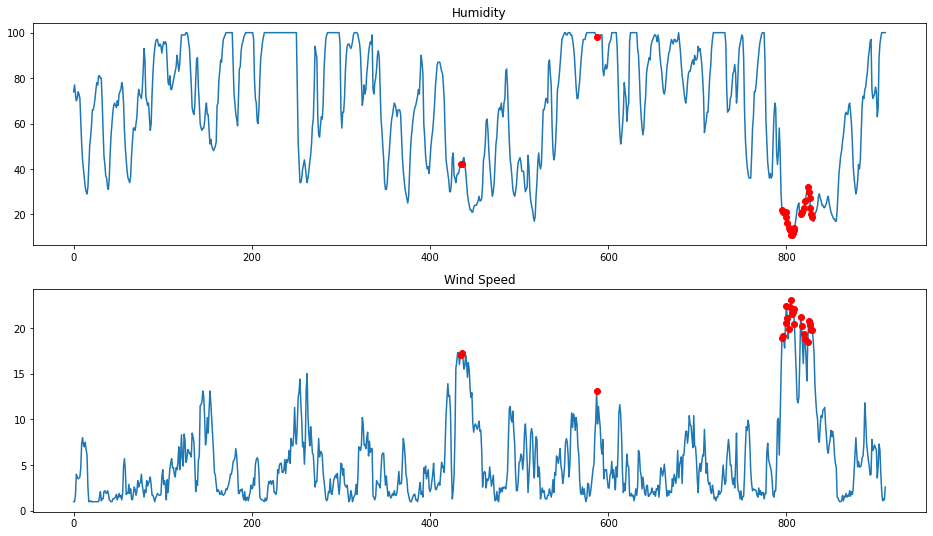

In [145]:
wr_adtk.reset_index(drop=True, inplace=True)
fig, ax = plt.subplots(2,1, figsize=(16,9))
ax[0].plot(wr_adtk["HlyRelHum (%)"])
ax[0].plot(wr_adtk[anomalies.values]["HlyRelHum (%)"], 'o', color='red')
ax[0].set_title("Humidity")

ax[1].plot(wr_adtk["HlyWindSpd (MPH)"])
ax[1].plot(wr_adtk[anomalies.values]["HlyWindSpd (MPH)"], 'o', color='red')
ax[1].set_title("Wind Speed")

## GlutonTS

In [21]:
wind_max = wr[["Station", "HlyWindSpd (MPH)"]].groupby("Station").max()
wind_max[wind_max > 31].dropna()

,HlyWindSpd (MPH)
Station,
121,35.6
140,34.8
212,32.5
248,31.7
261,36.2


In [22]:
wr_gts = wr[wr.Station==121]
wr_gts.set_index("Time", inplace=True)
wr_gts = wr_gts[wr_gts.columns[wr_gts.columns.str.contains("Hly")]]
wr_gts.tail()

,HlyAirTmp (F),HlyDewPnt (F),HlyEto (in),HlyNetRad (Ly/day),HlyAsceEto (in),HlyAsceEtr (in),HlyPrecip (in),HlyRelHum (%),HlyResWind (MPH),HlySoilTmp (F),HlySolRad (Ly/day),HlyVapPres (mBars),HlyWindDir (°),HlyWindSpd (MPH)
Time,,,,,,,,,,,,,,
2021-02-01 20:00:00,57.0,46.8,0.0,-62.0,0.0,NaN,0.0,69.0,8.3,52.3,0.0,10.9,210.0,8.5
2021-02-01 21:00:00,54.8,51.9,0.0,-58.0,0.0,NaN,0.0,90.0,8.9,52.3,0.0,13.2,224.0,9.0
2021-02-01 22:00:00,54.2,52.7,0.0,-57.0,0.0,NaN,0.0,95.0,9.8,52.4,0.0,13.6,224.0,9.9
2021-02-01 23:00:00,53.9,52.6,0.0,-57.0,0.0,NaN,0.0,95.0,11.5,52.4,0.0,13.5,225.0,11.6
2021-02-02 00:00:00,54.1,52.6,0.0,-57.0,0.0,NaN,0.0,95.0,11.3,52.4,0.0,13.5,214.0,11.5


<AxesSubplot:xlabel='Time'>

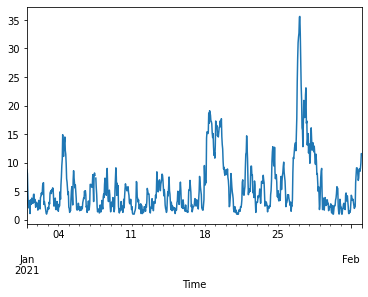

In [23]:
# fig, ax = plt.subplots(1,1, figsize=(20,5))
wr_gts.loc[wr_gts.index.month < 3, "HlyWindSpd (MPH)"].plot()

# ax.set_xlabel("Date")
# ax.set_ylabel("Wind Speed (MPH)")
# plt.title("Davis")

In [24]:
from gluonts.dataset.common import ListDataset

training_data = ListDataset(
    [{"start": wr_gts.index[0], "target": wr_gts[c][:"2021-01-25 00:00:00"]} for c in wr_gts.columns],
    freq = "60min")

In [25]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer

estimator = DeepAREstimator(freq="60min", prediction_length=24*5, trainer=Trainer(epochs=10))

In [26]:
predictor = estimator.train(training_data=training_data)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:14<00:00,  3.42it/s, epoch=10/10, avg_epoch_loss=1.08]


Skipping  0 HlyAirTmp (F)
Skipping  1 HlyDewPnt (F)
Skipping  2 HlyEto (in)
Skipping  3 HlyNetRad (Ly/day)
Skipping  4 HlyAsceEto (in)
Skipping  5 HlyAsceEtr (in)
Skipping  6 HlyPrecip (in)
Skipping  7 HlyRelHum (%)
Skipping  8 HlyResWind (MPH)
Skipping  9 HlySoilTmp (F)
Skipping  10 HlySolRad (Ly/day)
Skipping  11 HlyVapPres (mBars)
Skipping  12 HlyWindDir (°)
Showing  13 HlyWindSpd (MPH)


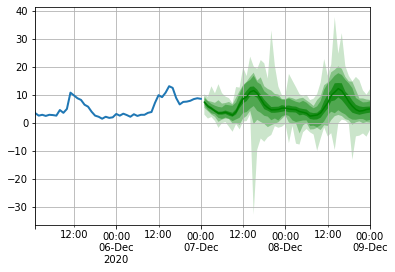

In [61]:
from gluonts.dataset.util import to_pandas
i = 0
for test_entry, forecast in zip(training_data, predictor.predict(training_data)):
    if i == len(wr_gts.columns)-1:
        print("Showing ", i, wr_gts.columns[i])
        to_pandas(test_entry)[-48:].plot(linewidth=2)
        forecast.plot(color='g', prediction_intervals=[50,90,95,99])
    else:
        print("Skipping ", i, wr_gts.columns[i])
        i+=1
plt.grid(which='both')

In [27]:
from gluonts.evaluation import make_evaluation_predictions

In [28]:
wr_test = wr[wr.Station==121]
wr_test.set_index("Time", inplace=True)
wr_test = wr_test[wr_test.columns[wr_test.columns.str.contains("Hly")]]

In [29]:
test_data = ListDataset(
    [{"start": wr_test.index[0], "target": wr_test[c][:"2021-01-30 00:00:00"]} for c in wr_gts.columns],
    freq = "60min"
)

In [30]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=1000,  # number of sample paths we want for evaluation
)

In [31]:
forecasts = list(forecast_it)
tss = list(ts_it)

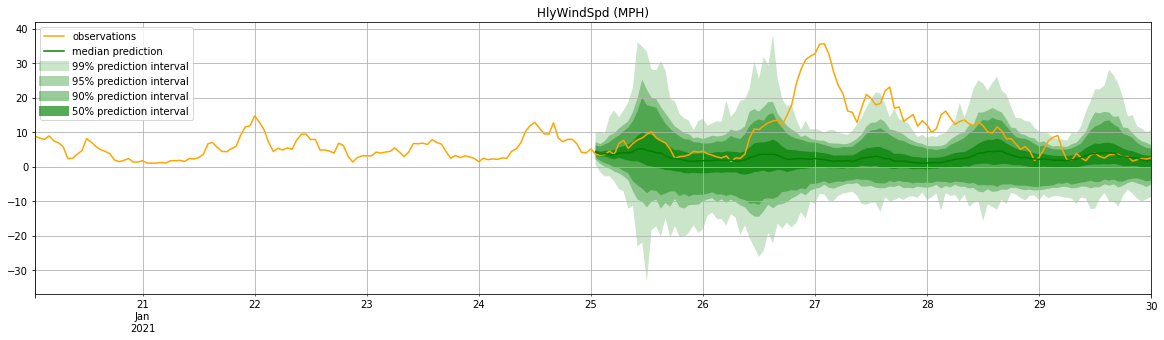

In [71]:
plot_length = 2*5*24
prediction_intervals = [50,90,95,99]
legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

fig, ax = plt.subplots(1, 1, figsize=(20, 5))
for i in [13]:
    tss[i][-plot_length:].plot(ax=ax, color="orange")  # plot the time series
    forecasts[i].plot(prediction_intervals=prediction_intervals, color='g')

#ax.set_xbound("2021-01-17", "2021-01-19")
#ax.set_ybound(0,100)
plt.title(wr_test.columns[i])
plt.grid(which="both")
plt.legend(legend, loc="upper left")
plt.show()

In [306]:
from gluonts.evaluation import Evaluator

In [331]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9, 0.95, 0.99])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data))

Running evaluation: 100%|██████████| 14/14 [00:00<00:00, 115.51it/s]WARNING:gluonts.time_feature.seasonality:Multiple 60 does not divide base seasonality 1. Falling back to seasonality 1.

/Users/tomityrrell/opt/anaconda3/envs/gluon-ts/lib/python3.7/site-packages/pandas/core/dtypes/cast.py:1516: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(values, dtype=dtype, copy=copy)


In [332]:
import json
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 4273.5503099257685,
    "abs_error": 72759.64903575182,
    "abs_target_sum": 138090.98112299852,
    "abs_target_mean": 63.228471210164166,
    "seasonal_error": 17.917226598851734,
    "MASE": 2004.456540348366,
    "MAPE": 73.81186080021835,
    "sMAPE": 0.9104988374116221,
    "OWA": NaN,
    "MSIS": 56583.599691533236,
    "QuantileLoss[0.1]": 33560.244213016755,
    "Coverage[0.1]": 0.28479853479853473,
    "QuantileLoss[0.5]": 72759.64931534314,
    "Coverage[0.5]": 0.63003663003663,
    "QuantileLoss[0.9]": 27131.554263551552,
    "Coverage[0.9]": 0.8424908424908424,
    "QuantileLoss[0.95]": 14873.619202116366,
    "Coverage[0.95]": 0.8933150183150182,
    "QuantileLoss[0.99]": 4458.89259215909,
    "Coverage[0.99]": 0.940018315018315,
    "RMSE": 65.37239715603037,
    "NRMSE": 1.0339076037239623,
    "ND": 0.526896459450486,
    "wQuantileLoss[0.1]": 0.24302994982072312,
    "wQuantileLoss[0.5]": 0.5268964614751752,
    "wQuantileLoss[0.9]": 0.19647593233757463,